# KBMod Analysis Demo

To run an example of kbmod from start to finish you can use the following steps:

1) Setup `kbmod` with the `setup.bash` file in the main directory of the repo by: `source setup.bash`

2) Run `example_search.py` with the following settings:

  * **image_dir**: The directory with the images from a single field
    
  * **results_dir**: The directory where you want to save the results
    
  * **results_suffix**: Suffix to add when saving results files. Setting this as `test` then files will be saved as "..._test.txt". Five results files would be saved:
      * `lc_test.txt`: File with the light curves from results after going through Kalman Filter.
      * `results_test.txt`: File with the x,y pixel locations, velocity, flux, likelihood, and number of unmasked observations of each result.
      * `ps_test.txt`: File with the summed postage stamp for each result.
      * `times_test.txt`: File with the MJD of each observation in the saved lightcurve.
      * `filtered_likes_test.txt`: The recalculated likelihood values for each results after removing observations with the Kalman Filter.
  * **time_file**: Location of a file with each row containing (visit_num, visit_mjd) for observations in dataset.
    
3) Command will be like the following:

```
python3 example_search.py --image_dir image_dir --results_dir results_dir --results_suffix test --time_file image_times.dat
```

4) Once you have the results you can use the steps in this notebook to create plots with postage stamps and lightcurves side-by-side for a final look by eye.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from create_stamps import create_stamps
%matplotlib inline

In [3]:
def loadStamps(results_dir,time_list,suffix):

    image_list = sorted(os.listdir(im_dir))
    image_list = [os.path.join(im_dir, im_name) for im_name in image_list]

    stamper = create_stamps()
    lc_filename = os.path.join(results_dir, 'lc_%s.txt' % suffix)
    psi_filename = os.path.join(results_dir, 'psi_{}.txt'.format(suffix))
    phi_filename = os.path.join(results_dir, 'phi_{}.txt'.format(suffix))
    lc_index_filename = os.path.join(results_dir, 'lc_index_%s.txt' % suffix)
    lc_list,lc_index = stamper.load_lightcurves(lc_filename,lc_index_filename)
    psi,phi,lc_index = stamper.load_psi_phi(psi_filename, phi_filename, lc_index_filename)
    stamp_filename = os.path.join(results_dir, 'ps_%s.txt' % suffix)
    result_filename = os.path.join(results_dir, 'results_%s.txt' % suffix)

    result_exists = os.stat(result_filename).st_size

    if result_exists:
        stamps = stamper.load_stamps(stamp_filename)
        all_stamps=np.load(os.path.join(results_dir, 'all_ps_%s.npy' % suffix))
        results = stamper.load_results(result_filename)
        keep_idx = []
        for lc_num, lc in list(enumerate(lc_list)):
            if len(lc) > 5:
                keep_idx.append(lc_num)
        return(keep_idx,results,stamper,stamps,all_stamps,lc_list,psi,phi,lc_index)
    else:
        warnings.warn('No results found. Returning 0')
        return(0,0,0,0,0,0,0)

In [54]:
allObjectData['legend']

['name', 'v_mag', '[v_x,v_y]', 'speed', 'angle', '[x_pixel,y_pixel]']

In [59]:
import pickle
with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/known_objects/allObjectData.pkl', 'rb') as f:
        allObjectData = pickle.load(f)
known_data = np.loadtxt('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/known_object_list.txt')
known_format = "pg{:03d}_ccd{:02d}"

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: No results found. Returning 0


14


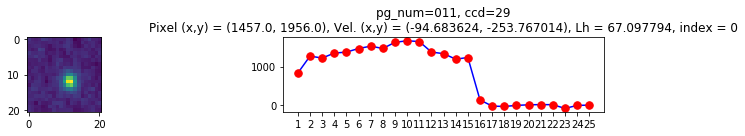

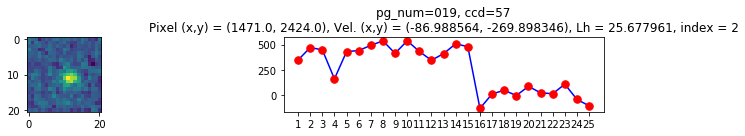

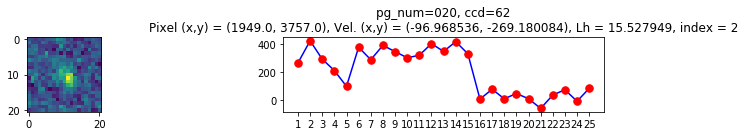

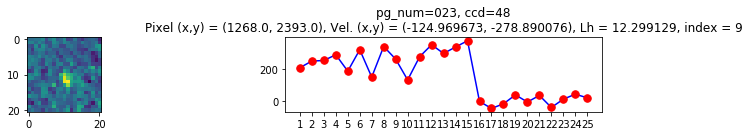

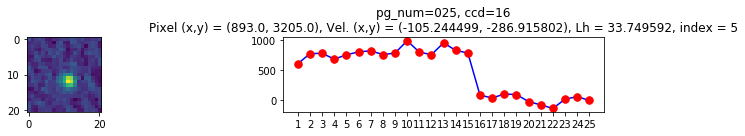

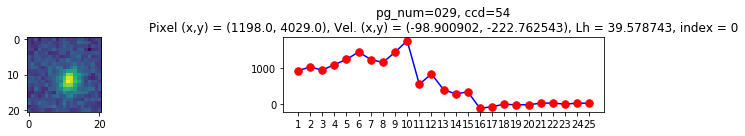

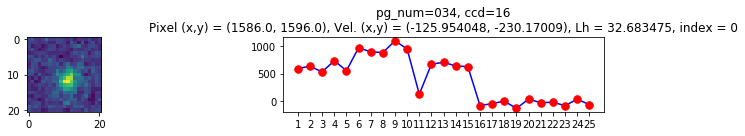

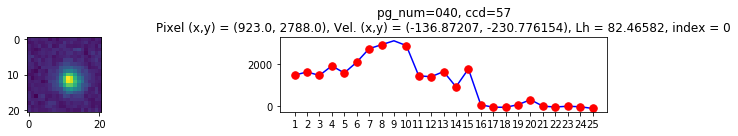

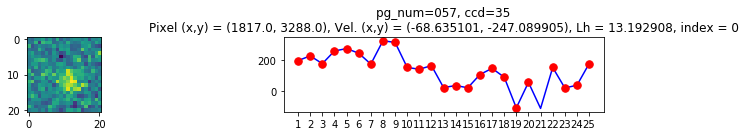

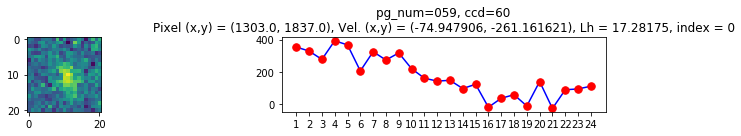

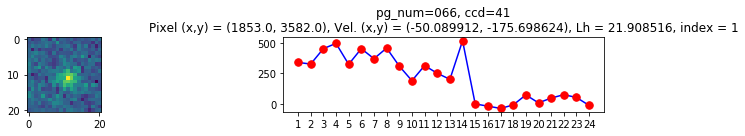

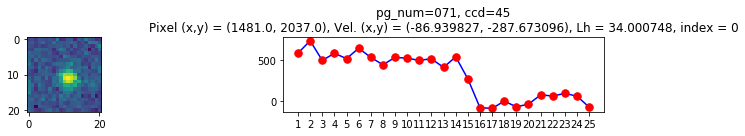

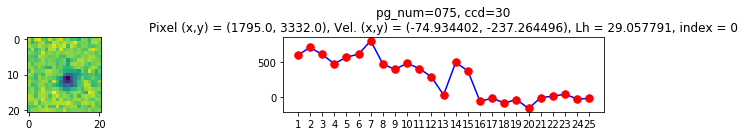

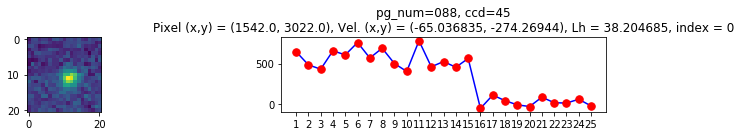

In [98]:
# Directory where output from kbmod search are located
num_found_objects=0
found_vmag = []
v_mag = []
for pgccd in known_data:
    pg_num = int(pgccd[0])
    ccd_num = int(pgccd[1])
    object_key = known_format.format(pg_num, ccd_num)
    xy_array = allObjectData[object_key][5]
    v_array = allObjectData[object_key][2]
    v_mag.append(allObjectData[object_key][1])
    results_dir = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    suffix = 'sigmaG_n2_2575_stamp'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)
    try:
        keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,times_list,suffix)
    except:
        continue

    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        stamps_fig, object_found = stamper.target_stamps(
            results, lc_list, lc_index, stamps, 0.03, xy_array, target_vel=v_array,
            vel_tol=15, atol=3, title_info='pg_num={:03d}, ccd={:02d}'.format(*pgccd.astype(int)))
        if object_found:
            num_found_objects+=1
            found_vmag.append(allObjectData[object_key][1])
print(num_found_objects)
        #stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)

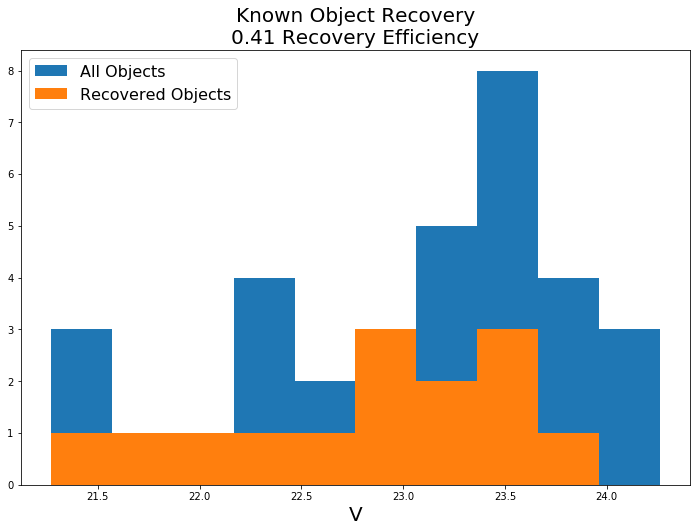

In [85]:
plt.figure(figsize=[12,8])
percent_recovered = len(found_vmag)/len(v_mag)
plt.hist(v_mag)
plt.hist(found_vmag,range=[np.min(v_mag),np.max(v_mag)])
plt.xlabel('V',fontsize=20)
plt.legend(['All Objects','Recovered Objects'],fontsize=16)
_=plt.title('Known Object Recovery\n{:.2f} Recovery Efficiency'.format(percent_recovered), fontsize=20)

[1458.1289606563355, 1957.3085753658502]
Center filtering keeps 4 out of 4 stamps.


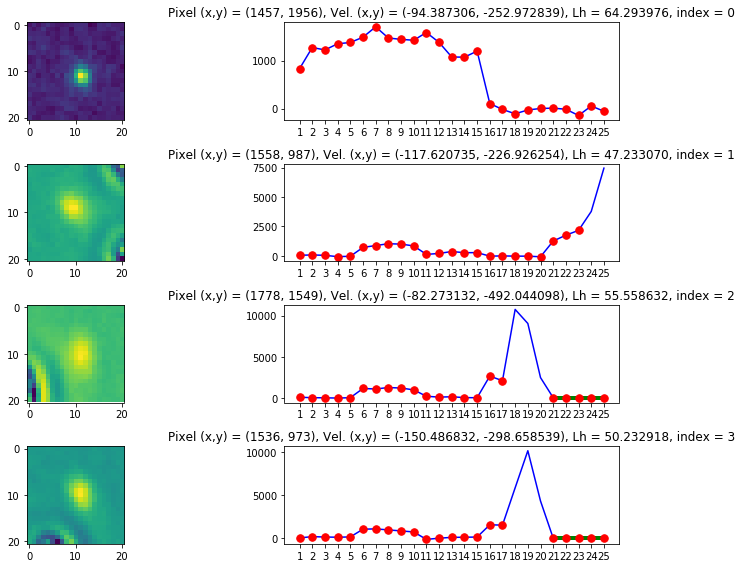

In [19]:
# Directory where output from kbmod search are located
pg_num=11
ccd_list=[29]

for ccd_num in ccd_list:
    xy_array = allObjectData[known_format.format(pg_num, ccd_num)][5]
    print(xy_array)
    results_dir = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    suffix = 'sigmaG_n2_2065'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)

    keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,times_list,suffix)

    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.03, target_xy=[1458.1289606563355,1957.3085753658502],rtol=0.001)
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.03, target_xy=xy_array,rtol=0.001)

        stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)

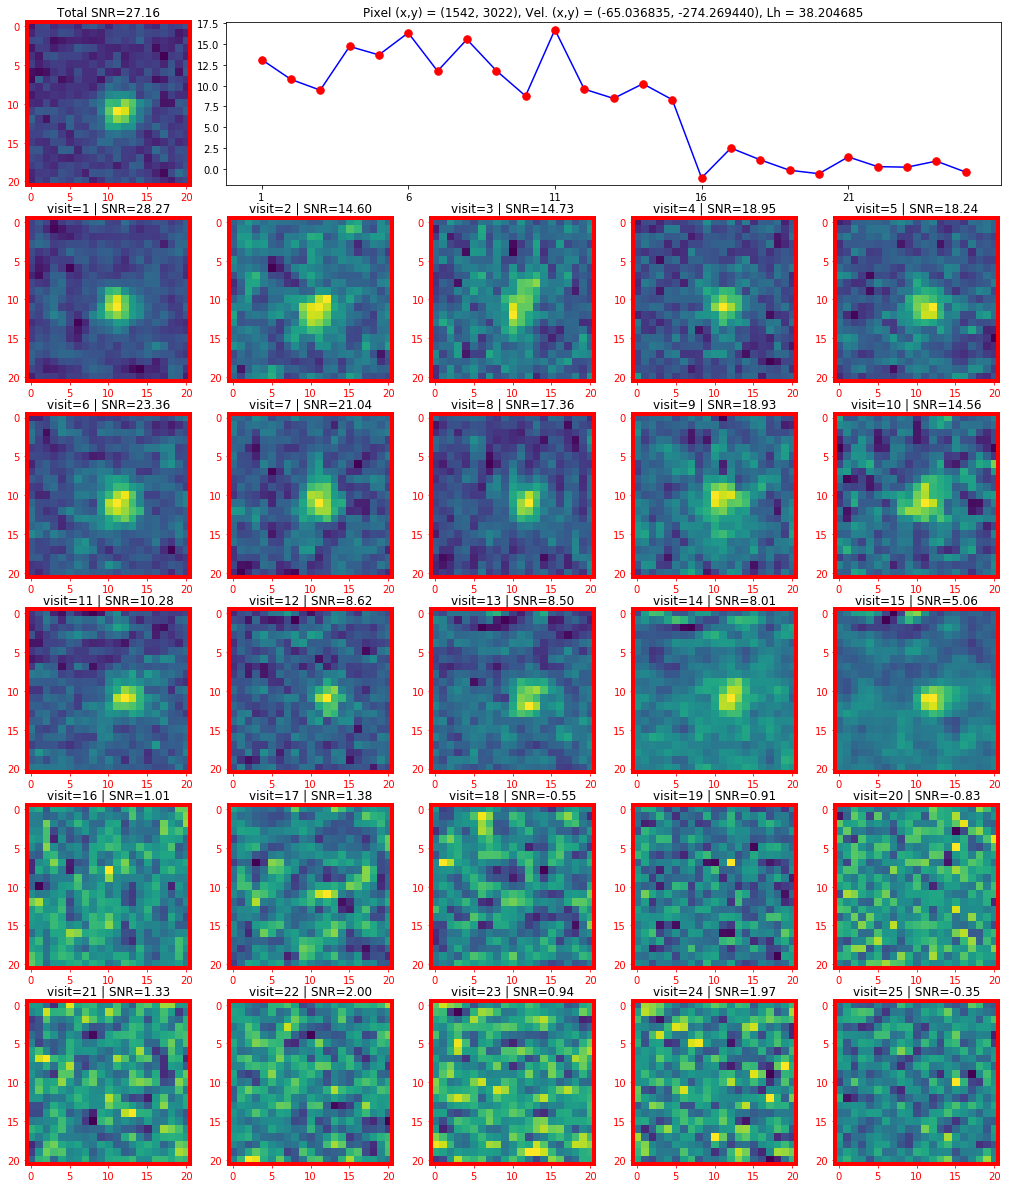

In [26]:
possible=[0]
stamper = create_stamps()
for i in possible:
    psi = psi_list[i]
    phi = phi_list[i]
    masked_phi = np.copy(phi)
    masked_phi[phi==0] = 1e9
    lh = psi/np.sqrt(masked_phi)
    fig = stamper.plot_all_stamps(results[i],lh,lc_index[i],stamps[i],all_stamps[i],sample=False)
    #fig = stamper.plot_all_stamps(results[i],lc_list[i],lc_index[i],stamps[i],all_stamps[i],sample=False)
#plt.savefig('DEEPNewObjectSample.png'.format(i))

In [ ]:

# Directory where output from kbmod search are located
ccd_list=[43]
for ccd_num in ccd_list:
    results_dir = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/A0b/results/{}/'.format(ccd_num)
    im_dir = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/A0b/warps/{}/'.format(ccd_num)
    #results_dir = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/results/{}/'.format(ccd_num)
    #im_dir = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/warps/{}/'.format(ccd_num)
    suffix = 'sG_3'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)

    keep_idx,results,stamper,stamps,all_stamps,lc_list,lc_index = makeStamps(results_dir,times_list,suffix)

    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.01, target_xy=[1217.9613127459104,325.56229130147136],rtol=0.06)
        stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.0)

In [19]:
l_num = 32
tl = np.array(np.sort(times_list[l_num]) - np.min(times_list[l_num]))
print(results[l_num]['vx']*tl + results[l_num]['x'], results[l_num]['vy']*tl + results[l_num]['y'])

[1692.         1692.22275539 1692.75831903 1759.98532658] [285.         285.41229966 286.40357849 410.83456107]


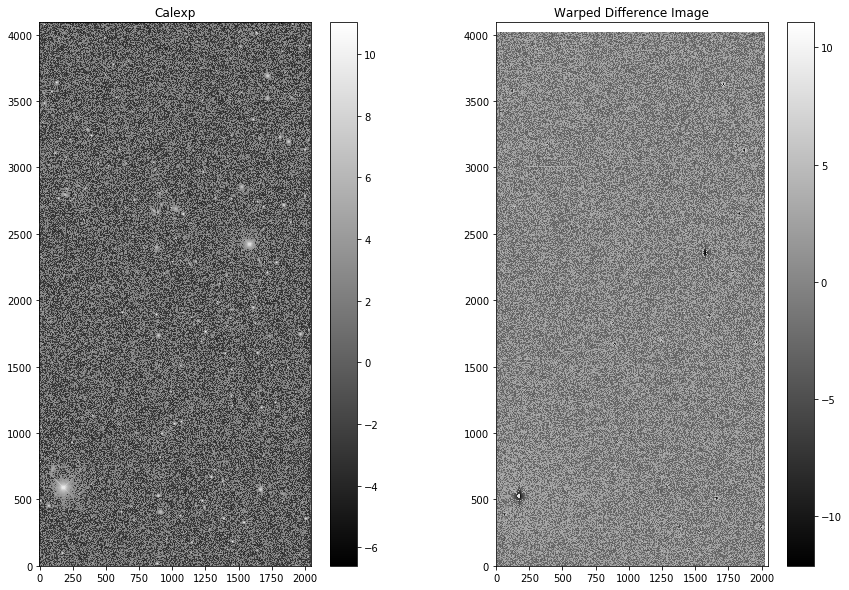

In [135]:
from astropy.io import fits
from matplotlib.patches import Circle

def normalFilter(data):
    return(data)

def plotImages(pg_num, ccd_num, visit_id, filter_type='arcsinh', zoom=False, zoom_mask=[250,750,250,500]):
    if filter_type==None:
        apply_filter=normalFilter
    elif filter_type=='arcsinh':
        apply_filter=np.arcsinh
    elif filter_type=='log':
        apply_filter=np.log
        
    fig,[ax1,ax2]=plt.subplots(nrows=1,ncols=2,figsize=[15,10])
    warps_path = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/warps/{ccd:02d}/{visit:06d}.fits'
    calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
    with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        im = ax1.imshow(apply_filter(data),origin='lower',cmap='gray')
        ax1.set_title('Calexp')
        fig.colorbar(im, ax=ax1)

    with fits.open(warps_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        ax2.set_title('Warped Difference Image')
        im = ax2.imshow(apply_filter(data),origin='lower',cmap='gray')
        fig.colorbar(im, ax=ax2)

plotImages(19, 57, 304994, zoom=False)

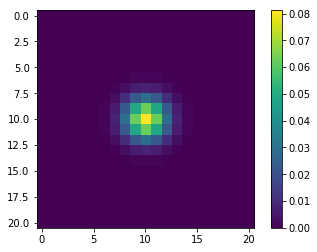

In [8]:
size = 21
sigma_x = 1.4
sigma_y = 1.4

x = np.linspace(-10, 10, size)
y = np.linspace(-10, 10, size)
x, y = np.meshgrid(x, y)
z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2)
     + y**2/(2*sigma_y**2))))
plt.imshow(z)
plt.colorbar()
plt.show()

In [109]:
v = [-105.28,-259.65]
np.linalg.norm(v)
np.arctan2(v[1],v[0])+2*np.pi

4.327176942788729